# Three steps to prepare a session:
1. Submit local PDB file
2. Submit local MOL2 file
3. Submit session preparation request

In [19]:
import requests
import json 

def RecallSession(jobid):
  """
  Primarily to obtain the session ligand and protein structure
  """
  data = {
      'cmd': 'recallSession',
      'JOBID': jobid,
  }
  response = requests.post('http://130.60.168.149/fcgi-bin/ACyang.fcgi', data=data)
  if response.status_code==200: 
    return json.loads(response.text)
  else: 
    return false

def SubmitPDB(pdbfile, jobid, pdbcode="USER", water="T3P"):
  with open(pdbfile, "r") as file1: 
    pdbstr = file1.read(); 
  data = {
      'cmd': 'deposittarget',
      'water': water,
      'hisdef': 'HID',
      'ligpdb': '',
      'ligname': '',
      'target': pdbstr,
      'targetname': pdbcode,
      'JOBID': jobid,
      'unsuppres': '',
  }
  response = requests.post('http://130.60.168.149/fcgi-bin/ACyang.fcgi', data=data)
  if response.status_code == 200: 
    dic = json.loads(response.text)
    print("Finished the submission of PDB: ", response.status_code,  response.url, response.text); 
    return dic
  else: 
    return False 

def SubmitMOL2(mol2file, jobid):
  with open(mol2file, "r") as file1: 
    mol2str = file1.read(); 
  data = f'cmd=depositligand&ligandmol2={mol2str}&JOBID={jobid}'; 
  response = requests.post('http://130.60.168.149/fcgi-bin/ACyang.fcgi', data=data); 
  if response.status_code == 200: 
    dic = json.loads(response.text)
    print("Finished the submission of MOL2: ", response.status_code,  response.url, response.text); 
    return dic
  else: 
    return False 

def PrepareSession(jobid, parms={}):
  """
  After uploading the protein PDB file and ligand MOL2, prepare the session
  """
  session_info = RecallSession(jobid); 
  if isinstance(session_info, dict):
    pdbfile = session_info["pdbfile"]; 
    molfile = session_info["molfile"]; 
    datadict = {'cmd': 'preptarget', 'water': '', 'nwaters': '0', 'fullpdb': pdbfile, 'JOBID': jobid, 
     'waterchoice': 'T3P', 'hischoice': 'HID', 'chainsel': 'none', 'ligand': 'none', 'ligmol2': molfile, 
     'ligsdf': '', 'maxloopl': '0', 'nrsteps': '5000', 'mini_mode': '3', 'mini_grms': '0.01', 
     'sc_polar': '1.0', 'sc_impsolv': '1.0', 'pdb_tolerance_a': '20.0', 'pdb_tolerance_b': '0.75+1.25', 
     'appendix': '# comment', 'unsuppres': '', 'OBpH': '7.4', 'OBpercept': '5'
    }
    for i in parms.keys():
      if i in datadict.keys():
        datadict[i] = parms[i]; 
      
    data = "";
    for key, val in datadict.items():
      data += f"{key}={val}&";
    data = data.strip("&"); 

    response = requests.post('http://130.60.168.149/fcgi-bin/ACyang.fcgi', data=data); 
    if response.status_code == 200: 
      dic = json.loads(response.text)
      status = dic["status"]; 
      print(f"System preparation exit status is {status}", response.status_code,  response.url, ); 
      return dic
    else: 
      return False 
  else: 
    print("Fatal: Failed to query the session info")
    return False 

def GetSessionPDB(jobid):
  session_info = RecallSession(jobid);
  return session_info["pdbfile"]
def GetSessionMOL2(jobid):
  session_info = RecallSession(jobid);
  return session_info["molfile"]
  
def PrepNewSession(parms):
  """
  Wrapper of PrepareSession function to submit a request to prepare a new session. 
  Available settings: 
    ['water', 'nwaters', 'fullpdb', 'JOBID', 'waterchoice', 'hischoice', 
    'chainsel', 'ligand', 'ligmol2', 'ligsdf', 'maxloopl', 'nrsteps', 
    'mini_mode', 'mini_grms', 'sc_polar', 'sc_impsolv', 'pdb_tolerance_a', 'pdb_tolerance_b', 
    'appendix', 'unsuppres', 'OBpH', 'OBpercept']
  A simple example: 
  >>> parms={
    "jobid" : "C4001CTU", 
    "pdbcode" : "1CTU", 
    "pdbfile" : "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined/1ctu/1ctu_protein.pdb", 
    "mol2file" : "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined/1ctu/1ctu_ligand.mol2",
    "nrsteps":1000,
  }
  >>> PrepNewSession(parms)
  """
  if "pdbcode" in parms.keys():
    pdbcode = parms["pdbcode"]
  else:
    pdbcode = "USER"
  print("Preparing the session", parms["jobid"], "; PDB code: ",  parms["jobid"]); 
  pdb_state = SubmitPDB(parms["pdbfile"], parms["jobid"], pdbcode=pdbcode, water="T3P"); 
  if isinstance(pdb_state, bool) and pdb_state == False: 
    return
  mol2_state = SubmitMOL2(parms["mol2file"], parms["jobid"]); 
  if isinstance(mol2_state, bool) and mol2_state == False: 
    return
  prep_keys = ['water', 'nwaters', 'fullpdb', 'JOBID', 'waterchoice', 'hischoice', 
               'chainsel', 'ligand', 'ligmol2', 'ligsdf', 'maxloopl', 'nrsteps', 
               'mini_mode', 'mini_grms', 'sc_polar', 'sc_impsolv', 'pdb_tolerance_a', 'pdb_tolerance_b', 
               'appendix', 'unsuppres', 'OBpH', 'OBpercept']
  prep_parms = {}
  for i in parms.keys():
    if i in prep_keys:
      prep_parms[i] = parms[i]
  
  prep_state = PrepareSession(parms["jobid"], parms=prep_parms)
  if isinstance(prep_state, bool) and prep_state == False: 
    return
  print("Finished the preparation of session ", parms["jobid"])



# Batch Preparation

In [5]:
import pandas as pd 
from os import path 
from BetaPose import session_prep
import json 

# Currently have to remove too many HIV protease. 


Template = {
  # "ligsdf"   : "/tmp/tmp.sdf",   # optional 
  "jobid"    : "XXXXXXXX", 
  "pdbcode"  : "XXXX", 
  "pdbfile"  : "/tmp/tmp.pdb", 
  "mol2file" : "/tmp/tmp.mol2",
  "nrsteps"  : 1000,
}

csvfile = "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined/index/test107.csv"
basepath = "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined"
stepnr = 5000

table = pd.read_csv(csvfile, index_col=0)
bpath = path.abspath(basepath)
final_dict = {}
for i, row in table.iterrows(): 
  thesubmission = {i:j for i,j in Template.items()}; 
  thesubmission["pdb"] = row.PDB.upper(); 
  pdbcode = row.PDB.lower(); 
  
  pdbfile = path.join(bpath, f"{pdbcode}/{pdbcode}_protein.pdb"); 
  mol2file = path.join(bpath, f"{pdbcode}/{pdbcode}_ligand.mol2"); 
  
  if path.isfile(pdbfile) and path.isfile(mol2file): 
    thesubmission["jobid"]    = f"C400{pdbcode.upper()}"
    thesubmission["pdbfile"]  = pdbfile;
    thesubmission["mol2file"] = mol2file;
    thesubmission["stepnr"]   = stepnr; 
    session_prep.PrepNewSession(thesubmission); 
    final_dict[pdbcode.upper()] = thesubmission; 
    with open(f"{bpath}/C400Sessions.json", "w") as file1: 
      file1.write(json.dumps(final_dict))
      
  elif not path.isfile(mol2file):
    print(f"Cannot find the ligand MOL2 file: {mol2file}")
    
  elif not path.isfile(pdbfile):
    print(f"Cannot find the protein PDB file: {pdbfile}")
     

Preparing the session C4001Y6Q ; PDB code:  C4001Y6Q
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}

Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}




KeyboardInterrupt



In [1]:
from BetaPose import session_prep
Template = {
  "jobid"    : "XXXXXXXX", 
  "pdbcode"  : "XXXX", 
  "pdbfile"  : "/tmp/tmp.pdb", 
  "mol2file" : "/tmp/tmp.mol2",
  "nrsteps"  : 1000,
}
session_prep.PrepNewSession(parms)

Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}

Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}

System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001CTU


In [3]:
import pandas as pd 
from os import path 
from BetaPose import session_prep
import json 

# Currently have to remove too many HIV protease. 


Template = {
  # "ligsdf"   : "/tmp/tmp.sdf",   # optional 
  "jobid"    : "XXXXXXXX", 
  "pdbcode"  : "XXXX", 
  "pdbfile"  : "/tmp/tmp.pdb", 
  "mol2file" : "/tmp/tmp.mol2",
  "nrsteps"  : 1000,
}

csvfile = "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined/index/test107.csv"
basepath = "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined"
stepnr = 5000

table = pd.read_csv(csvfile, index_col=0)
bpath = path.abspath(basepath)
final_dict = {}

def do_it(pdbcode):
  pdbcode = pdbcode.lower(); 
  thesubmission = {i:j for i,j in Template.items()}; 
  thesubmission["pdb"] = pdbcode.upper(); 
  
  pdbfile = path.join(bpath, f"{pdbcode}/{pdbcode}_protein.pdb"); 
  mol2file = path.join(bpath, f"{pdbcode}/{pdbcode}_ligand.mol2"); 
  
  if path.isfile(pdbfile) and path.isfile(mol2file): 
    thesubmission["jobid"]    = f"C400{pdbcode.upper()}"
    thesubmission["pdbfile"]  = pdbfile;
    thesubmission["mol2file"] = mol2file;
    thesubmission["stepnr"]   = stepnr; 
    session_prep.PrepNewSession(thesubmission); 
    # final_dict[pdbcode.upper()] = thesubmission; 
      
  elif not path.isfile(mol2file):
    print(f"Cannot find the ligand MOL2 file: {mol2file}")
    
  elif not path.isfile(pdbfile):
    print(f"Cannot find the protein PDB file: {pdbfile}")
  return thesubmission
# do_it("1Y6Q")

In [4]:
import multiprocessing as mp; 
import time; 

csvfile = "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined/index/test110.csv"; 
table = pd.read_csv(csvfile, index_col=0); 

pool = mp.Pool(20);
results = pool.starmap(do_it, [(i,) for i in table.PDB]);
pool.close();
pool.join();

Preparing the sessionPreparing the sessionPreparing the sessionPreparing the sessionPreparing the sessionPreparing the sessionPreparing the sessionPreparing the session Preparing the sessionPreparing the sessionPreparing the session  Preparing the session  Preparing the session   C4001YDT Preparing the sessionPreparing the sessionC4007STDC4001J17Preparing the session Preparing the sessionC4001GI7Preparing the sessionPreparing the sessionC4001B1H   C4001NVRC4001FKGC4001PPC     C4001B40C4002QE4  C4001LAF  C4002JDS C4001NC3 ; PDB code:  ; PDB code: C4001PXPC4001HMS Preparing the session ; PDB code: ; PDB code: ; PDB code: ; PDB code:       C4002F81; PDB code: ; PDB code:   ; PDB code:    C4001NVRC4001OS5; PDB code: C4001NC3; PDB code:  
; PDB code: C4001HMS 
; PDB code:    
 C4001XOW C4001J17C4001PXPC4001FKG
 C4002JDSC4001DHI
C4001YDT; PDB code: C4001E1V 
 C4001OS5C4001PPC; PDB code:  
C4007STD  ; PDB code: 

; PDB code:  C4002F81; PDB code: C4001B40 
  C4002QE4C4001GI7

 C4001LAF C4001B1

System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001UWF
Preparing the session C4001TOM ; PDB code:  C4001TOM
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001Y6Q
Preparing the session C4001ZGI ; PDB code:  C4001ZGI
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001ELA
Preparing the session C4001FCX ; PDB code:  C4001FCX
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}

Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}

System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001B9J
Preparing the session C4001O5C ; PDB code:  C4001O5C
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"st

Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}

Finished the submission of MOL2:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}

System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4003BUF
Preparing the session C4002QBQ ; PDB code:  C4002QBQ
Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"status":1}

Finished the submission of PDB:  200 http://130.60.168.149/fcgi-bin/ACyang.fcgi {"logerrlk":"ERRORLOGS/C4002PVK_err.txt","message":"CAMPARI failed in the conversion stage. This usually indicates the presence of unsupported features in the PDB file.","status":-1}

System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finished the preparation of session  C4001KV1
Preparing the session C4003BRN ; PDB code:  C4003BRN
System preparation exit status is 1 200 http://130.60.168.149/fcgi-bin/ACyang.fcgi
Finis

# Evaluate the prepared structure. 

In [2]:
import pandas as pd
from BetaPose import utils, session_prep
import numpy as np 

csvfile = "/home/yzhang/Documents/Personal_documents/BetaPose/test110.csv"; 
table = pd.read_csv(csvfile, index_col=0); 

def exp(code):
  return f"C400{code.upper()}"

tmscores = []
sessions = []
dist_after = []
for i in table.PDB:
  sessid = exp(i)
  try: 
    score = session_prep.CompareStructures(i, sessexp=exp)
    tmscores.append(score)
    sessions.append(sessid)
  except Exception as e: 
    print(f"Warning: Failed to compute the session {exp(i)}")
    tmscores.append(0)
    sessions.append(sessid)
    
  try: 
    dist = utils.DistanceLigPro(sessid, mode="session")
    dist_after.append(dist)
  except Exception as e: 
    dist_after.append(999)
    
    
if len(tmscores) == len(table): 
  table["TMScore"] = tmscores
if len(sessions) == len(table): 
  table["sess_id"] = sessions

if len(dist_after) == len(table): 
  table["distA"] = dist_after
  

# 2 Sessions are failed "C4003D83_err" "C4002PVK_err"


The session ID is : C4001GI7
Coordinate set 1 shaped (254, 3) ; Sequence shape 254
Coordinate set 2 shaped (236, 3) ; Sequence shape 236
TM_Score: Chain1 0.8504414147167677 ; Chain2 0.9151832448116692
TM_Score: Good match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4001YDK
Coordinate set 1 shaped (426, 3) ; Sequence shape 426
Coordinate set 2 shaped (420, 3) ; Sequence shape 420
TM_Score: Chain1 0.9859154929577465 ; Chain2 1.0
TM_Score: Good match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4001PPC
Coordinate set 1 shaped (223, 3) ; Sequence shape 223
Coordinate set 2 shaped (220, 3) ; Sequence shape 220
TM_Score: Chain1 0.9865470852017937 ; Chain2 1.0
TM_Score: Good match
The session ID is : C4002A8G
Coordinate se

The session ID is : C4001XOW
Coordinate set 1 shaped (253, 3) ; Sequence shape 253
Coordinate set 2 shaped (235, 3) ; Sequence shape 235
TM_Score: Chain1 0.6689658455590156 ; Chain2 0.7199709857191254
TM_Score: Bad match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4003D0B
Coordinate set 1 shaped (208, 3) ; Sequence shape 208
Coordinate set 2 shaped (204, 3) ; Sequence shape 204
TM_Score: Chain1 0.5225947314042159 ; Chain2 0.5328038090805839
TM_Score: Bad match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4002QE4
Coordinate set 1 shaped (411, 3) ; Sequence shape 411
Coordinate set 2 shaped (389, 3) ; Sequence shape 389
TM_Score: Chain1 0.3240454789923142 ; Chain2 0.34155736612878174
TM_Score: Bad match
Error occurred

The session ID is : C4003BEX
Coordinate set 1 shaped (1488, 3) ; Sequence shape 1488
Coordinate set 2 shaped (482, 3) ; Sequence shape 482
TM_Score: Chain1 0.3239247311827957 ; Chain2 1.0
TM_Score: Good match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4003D83
Coordinate set 1 shaped (347, 3) ; Sequence shape 347
Coordinate set 2 shaped (347, 3) ; Sequence shape 347
TM_Score: Chain1 1.0 ; Chain2 1.0
TM_Score: Good match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4001R5Y
Coordinate set 1 shaped (385, 3) ; Sequence shape 385
Coordinate set 2 shaped (353, 3) ; Sequence shape 353
TM_Score: Chain1 0.6610359194054464 ; Chain2 0.7198731676897062
TM_Score: Bad match
Error occurred while calculating the Ligand COM: n_atoms

The session ID is : C4001NVS
Coordinate set 1 shaped (269, 3) ; Sequence shape 269
Coordinate set 2 shaped (257, 3) ; Sequence shape 257
TM_Score: Chain1 0.8355838065938092 ; Chain2 0.8741149133004297
TM_Score: Good match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4002ZB1
Coordinate set 1 shaped (347, 3) ; Sequence shape 347
Coordinate set 2 shaped (333, 3) ; Sequence shape 333
TM_Score: Chain1 0.5698487347790692 ; Chain2 0.5924883653718697
TM_Score: Bad match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4003EKO
Coordinate set 1 shaped (438, 3) ; Sequence shape 438
Coordinate set 2 shaped (213, 3) ; Sequence shape 213
TM_Score: Chain1 0.4863013698630137 ; Chain2 1.0
TM_Score: Good match
Error occurred while calcula

RDKit ERROR: [18:11:25] 
[18:11:25] 

****
Post-condition Violation
Element 'LP' not found
Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1646569075455/work/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[18:11:25] 

****
Post-condition Violation
Element 'LP' not found
Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1646569075455/work/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[18:11:25] 

****
Post-condition Violation
Element 'LP' not found
Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1646569075455/work/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[18:11:26] 

****
Post-condition Violation
Element 'LP' not found
Violation occurred on line 91 in file /home/conda/feedstock_root/build_artifacts/rdkit_1646569075455/work/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[18:11:36] 

****
Post-cond

The session ID is : C4002PCP
Coordinate set 1 shaped (862, 3) ; Sequence shape 862
Coordinate set 2 shaped (422, 3) ; Sequence shape 422
TM_Score: Chain1 0.4895591647331787 ; Chain2 1.0
TM_Score: Good match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4001P1N
Coordinate set 1 shaped (258, 3) ; Sequence shape 258
Coordinate set 2 shaped (512, 3) ; Sequence shape 512
TM_Score: Chain1 0.5953421797329108 ; Chain2 0.30470631980675755
TM_Score: Bad match
Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
The session ID is : C4003CJ5
Coordinate set 1 shaped (1125, 3) ; Sequence shape 1125
Coordinate set 2 shaped (547, 3) ; Sequence shape 547
TM_Score: Chain1 0.3695836923295862 ; Chain2 0.7553922877730259
TM_Score: Bad match
Error occurred while calcu

In [4]:
table
with open(csvfile, "w") as file1: 
  file1.write(table.to_csv())

        PDB  affinity   sess_id   TMScore
index                                    
70     1e1v      4.92  C4001E1V  0.890195
102    1nvr      8.11  C4001NVR  0.856809
164    1pxp      6.66  C4001PXP  0.874666
265    2brm      5.89  C4002BRM  0.869044
434    1df8      9.70  C4001DF8  0.854599
474    1nvs      7.82  C4001NVS  0.874115


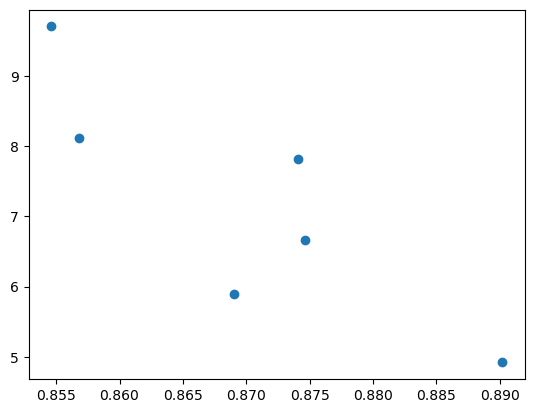

In [26]:
import matplotlib.pyplot as plt
st = (table.TMScore > 0.8) * (table.TMScore < 0.9) 
a = table[st][["PDB", "affinity","sess_id", "TMScore"]]
print(a)

plt.scatter(a.TMScore, a.affinity)

In [1]:
# from rdkit import Chem
# from scipy.spatial import distance_matrix
# import re
import tempfile
from BetaPose import utils, session_prep

def DistanceLigPro(theid, mode="session", ligname="LIG"):
  """
    Calculate the COM distance from protein to ligand
    Protein uses CA atoms ; Ligand use ALL atoms
    Have 2 modes: session/file
  """
  import pytraj as pt
  if mode == "session":
    from rdkit import Chem
    from scipy.spatial import distance_matrix
    import re
    import numpy as np 
    if len(theid) != 8: 
      print("Session ID length not equil to 8");
      return
    with tempfile.NamedTemporaryFile("w", suffix=".pdb") as file1, tempfile.NamedTemporaryFile("w", suffix=".mol2") as file2:
      session = session_prep.RecallSession(theid)
      file1.write(session["pdbfile"]); 
      protcom = pt.center_of_mass(pt.load(file1.name), "@CA"); 
      try:
        # Mol2 could successfully be parsed in pytraj
        file2.write(session["molfile"]); 
        traj = pt.load(file2.name)
        ligcom = pt.center_of_mass(pt.load(file2.name)); 
      except Exception as e: 
        # Directly calculate the COM of the ligand 
        print(f"Error occurred while calculating the Ligand COM: {e}")
        atoms = session["molfile"].split("@<TRIPOS>ATOM\n")[1].split("@<TRIPOS>")[0]; 
        atoms = [i.strip().split() for i in atoms.strip("\n").split("\n")]; 
        coord = np.array([i[2:5] for i in atoms]).astype(np.float32); 
        atomtypes = [re.sub(r"[0-9]", "", i[1]) for i in atoms]; 
        masses = []; 
        for i in atomtypes:
          try: 
            m = Chem.Atom(i).GetMass()
            masses.append(m); 
          except: 
            masses.append(0); 
        com = np.average(coord, axis=0, weights=masses)
        ligcom = np.array([com])
      return distance_matrix(ligcom, protcom).item(); 
  elif mode == "file": 
    traj = pt.load(theid); 
    dist = pt.distance(traj, f"@CA  :{ligname}")
    return dist.item()
  else:
    return None
  
utils.DistanceLigPro("C4001PXP", mode="session")
a="/home/yzhang/Downloads/step135b.pdb"
x = utils.DistanceLigPro(a, mode="file"); 
print(x)

#   DistanceLigPro(file1.name)
  
  



Error occurred while calculating the Ligand COM: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)
12.032900453309477
